<a href="https://colab.research.google.com/github/so-yeon-hwang/DataSciencePractice/blob/main/23_11_08_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip # url에 있는 파일을 다운로드해줌
!unzip ml-100k.zip # zip 압축해제

--2023-11-08 00:14:31--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  9.08MB/s    in 0.5s    

2023-11-08 00:14:32 (9.08 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('ml-100k/ua.base', sep='\t',names = ['user','movie','rating','timestamp'])
test = pd.read_csv('ml-100k/ua.test', sep='\t',names = ['user','movie','rating','timestamp'])

In [ ]:
# tensor로 만들기 LongTensor

items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])


In [ ]:
items

tensor([   1,    2,    3,  ..., 1188, 1228, 1330])

In [ ]:
print(items.shape)
print(users.shape)
print(ratings.shape)

torch.Size([90570])
torch.Size([90570])
torch.Size([90570])


In [ ]:
items_test

tensor([  20,   33,   61,  ...,  570,  808, 1067])

In [ ]:
items_test.shape

torch.Size([9430])

In [ ]:
rank = 10 # 사용자 vector 아이템 vector의 차원
numItems = items.max() + 1 # index는 0부터 시작이기 때문에 +1 해주기, 유저는 1부터 시작함
numUsers = users.max() + 1

# 업데이터해야 하는 파라미터
P = torch.randn(numItems,rank,requires_grad=True) # 학습대상
Q = torch.randn(numUsers,rank,requires_grad=True)


In [ ]:
# 가설함수 P와 Q를 곱한다.
P

tensor([[ 1.4004,  0.9387,  0.4985,  ..., -0.4946,  0.4576, -0.1699],
        [ 0.1867, -1.1470,  0.5744,  ..., -0.9247, -0.2794,  0.5534],
        [-0.2923,  0.2134,  0.9738,  ..., -0.4112,  0.1638,  0.2973],
        ...,
        [-0.5498,  0.3786,  0.3178,  ..., -0.9779,  0.4367,  0.6913],
        [-0.8575,  0.5440, -0.7463,  ...,  0.3329, -1.1849,  2.0947],
        [-0.7601, -0.9482,  0.5683,  ...,  0.0275, -0.1669, -0.6053]],
       requires_grad=True)

In [ ]:
P[items]

tensor([[ 0.1867, -1.1470,  0.5744,  ..., -0.9247, -0.2794,  0.5534],
        [-0.2923,  0.2134,  0.9738,  ..., -0.4112,  0.1638,  0.2973],
        [ 1.6576,  0.7744, -1.2595,  ...,  0.7285, -0.0867,  1.3550],
        ...,
        [ 0.5911,  0.2871, -0.7793,  ..., -1.8051, -0.0260,  0.0383],
        [ 1.4467, -0.8662, -1.7167,  ..., -1.5228, -0.1200,  0.2062],
        [-1.4362,  1.4622, -0.8905,  ...,  0.3726,  0.4538, -1.9385]],
       grad_fn=<IndexBackward0>)

In [ ]:
P[items].shape

torch.Size([90570, 10])

In [ ]:
P.shape

torch.Size([1683, 10])

In [ ]:
X = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
print(X)
print(X[[0,0,0,1]])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [4, 5, 6]])


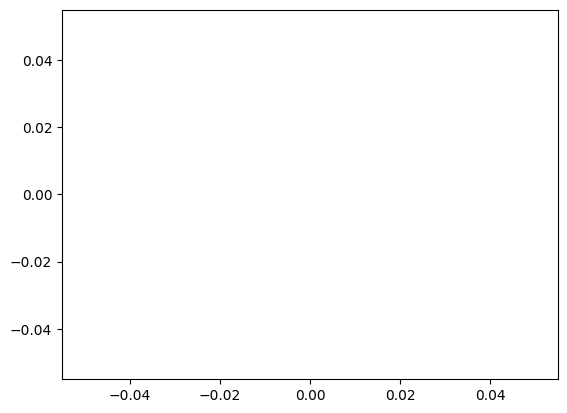

In [ ]:
optimizer = torch.optim.Adam([P,Q], lr = 0.1)
for epoch in range(1001):
  h = torch.sum(P[items] * Q[users],dim = 1)
  cost = F.mse_loss(h,ratings)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X = []
  Y = []

  Y_test = []
  with torch.no_grad():
   hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
   cost_test = F.mse_loss(hypo_test, ratings_test)
   Y_test.append(cost_test)


In [ ]:
Y_test = []
with torch.no_grad():
  X.append(epoch)
  Y.append(cost.item())
  h_test = (P[items_test] * Q[users_test]).sum(dim=1)
  cost_test = mse(h_test, ratings_test)
  Y_test.append(cost_test.item())


In [ ]:
mse = torch.nn.MSELoss()
cost = mse(h,ratings)

In [ ]:
(P[20] * Q[1]).sum() # 20번 무비, 1번 user

tensor(3.5801, grad_fn=<SumBackward0>)

In [ ]:
lambda1 = 0.0001
lambda2 = 0.0001

rank = 10 # 사용자 vector 아이템 vector의 차원
numItems = items.max() + 1 # index는 0부터 시작이기 때문에 +1 해주기, 유저는 1부터 시작함
numUsers = users.max() + 1

# 업데이터해야 하는 파라미터
P = torch.randn(numItems,rank,requires_grad=True) # 학습대상
Q = torch.randn(numUsers,rank,requires_grad=True)

X = []
Y = []
Y_test = []

for epoch in range(1000):
  hypothesis = torch.sum(P[items] * Q[users], dim=1)
  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
  print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))


In [ ]:
mean = ratings.mean()

cost_reg = cost + lambda1 * (P ** 2).mean() + lambda2 * (Q ** 2).mean() + lambda3 * (bias_item ** 2)